In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import ad_server
import distributions
import simulation

In [2]:
windows = 24 * 60
requests = 2_000

base_distribution = distributions.custom_dist(windows)
requests_distribution = distributions.traffic_dist(base_distribution, requests)
campaigns = [ad_server.Campaign(1, 900, 1), ad_server.Campaign(2, 1_800, 2)]
pacing = ad_server.ThrottledPacing(base_distribution, 2 * 60)
# select_win = pacing.first_price_auction
select_win = ad_server.second_price_auction
process = ad_server.AdServer(pacing, select_win, campaigns)

In [3]:
sim = simulation.Simulation(requests_distribution, process)

In [4]:
df = pd.DataFrame(e.to_dict() for e in sim.run())

In [5]:
win_values_df = df[df["kind"] == "win"].set_index(["request", "window", "campaign_id"]).unstack()["bid_value"]

In [6]:
win_values_in_windows_df = win_values_df.fillna(0).groupby("window").sum()

In [7]:
total_win_value_df = win_values_in_windows_df.sum()

In [8]:
budget_spending_df = win_values_in_windows_df.cumsum() / total_win_value_df

In [9]:
perfect_budget_spending_df = distributions.normalize(requests_distribution).cumsum()

<AxesSubplot:xlabel='window'>

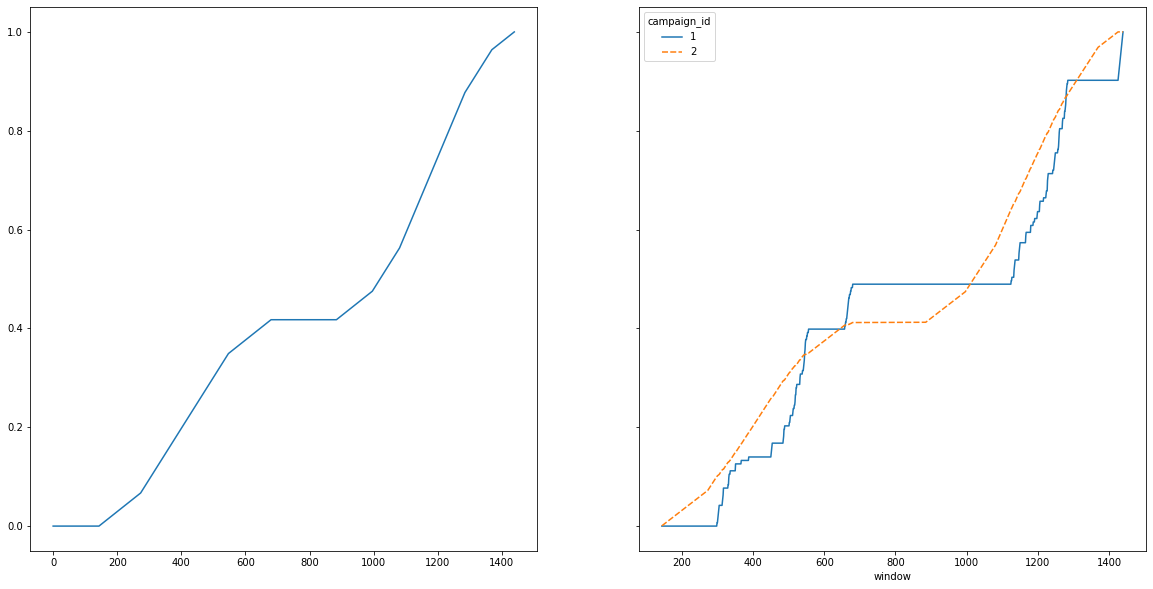

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey="row", figsize=(20, 10))
sns.lineplot(data=perfect_budget_spending_df, ax=ax1)
sns.lineplot(data=budget_spending_df, ax=ax2)